In [1]:
%%capture
%load_ext iventure.magics
%matplotlib inline

In [2]:
%ripl --seed 0 --plugins utils.py plotting.py

Set seed of a new RIPL instance for VentureScript to 0.00
Loading: /scratch/ulli/gpmem_notebooks/inverse_compilation/utils.py
Loading: /scratch/ulli/class-9s915-f2016-assets/10-18-problem-set-3/plotting.py


# Loading the Data

In [3]:
%%venturescript
define path = "data/airline.mat";
define data_airline_in = get_data_xs(path);
define data_airline_out  = get_data_ys(path);

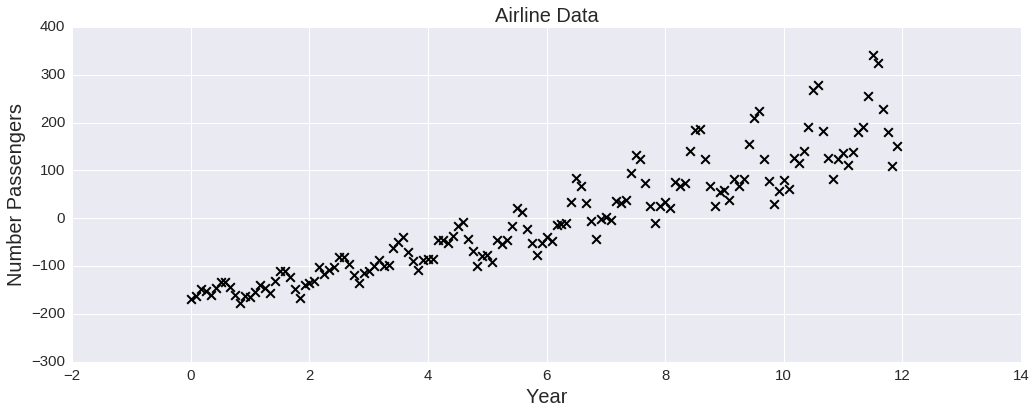

In [4]:
%%venturescript

define plotting_parameters_scatter = dict(
        ["xlabel", "Year"],
        ["ylabel", "Number Passengers"],
        ["label", "Observations"],
        ["width", 17],
        ["height", 6],
        ["markersize", 75]

);
scatter_plot(data_airline_in, data_airline_out, plotting_parameters_scatter);
title("Airline Data");

# Probabilistic Inverse Compilation

Below is the version of the code that is reported in the paper. Minus the differences listed here (__in order to display line numbers, press l  in command mode__):
 - `gp_cov_bump(0.000000001, 0.00000000001)` ((a) - Prior, line 47) is reported as `gp_cov_delta()`. Why? Because the bump kernel is
    invention of the Probcomp group - parameterized with such small values is emulates the commonly known delta kernel. I   say commonly because it can be found in common GP libraries and in the second automated statistician paper.
 - noisy observation model is baked into the gp. 
 - the `infer` keyword does not work in the inference language if used inside a loop therefore it is omitted in (c) - Inference, lines 3 and 5;
 - the `random_singleton` keyword ((c) - Inference, lines 3 and 5) is reported as just `random` - which I think is
   clearer;
 - `grad_ascent` ((c) - Inference, line 3) is reported as `gradient`;
 - `grad_ascent` ((c) - Inference, line 4) is not parameterized with a keyword `steps=X` - instead it takes two parameters r related to the number of steps, one for the number of gradient steps, one for the number of transitions taken at a subproblem;  it also takes in the steps size parameter that scales the gradient steps;
 - `mh` ((c) - Inference, line 5) is reported with a better name: `resimulate`; and
 - `mh` ((c) - Inference, line 6) is not parameterized with a keyword `steps=X` - instead it takes the number of transitions at a subproblem.

## (a) - Prior

In [5]:
%%venturescript
assume choose_primitive =  ( ) -> {
  rolled_dice = uniform_discrete(0,5);
  cond(        
    (rolled_dice == 0)(["WN",  -log_logistic(log_odds_uniform() 
                               #hypers:uniform_continuous(0,1))]),
    (rolled_dice == 1)(["C",   -log_logistic(log_odds_uniform() 
                               #hypers:uniform_continuous(0,1))]),
    (rolled_dice == 2)(["LIN", -log_logistic(log_odds_uniform() 
                               #hypers:uniform_continuous(0,1))]),
    (rolled_dice == 3)(["SE",  0.01 - log_logistic(log_odds_uniform() 
                               #hypers:uniform_continuous(0,1))]),
    (rolled_dice == 4)(["PER", 0.01 - log_logistic(log_odds_uniform() 
                               #hypers:uniform_continuous(0,1)),
                               0.01 - log_logistic(log_odds_uniform() 
                               #hypers:uniform_continuous(0,1))]),
    else("error"))
};




assume choose_operator = ( ) -> {
  if (flip() #structure:uniform_continuous(0,1))
    { "+" }
  else
    { "*" }
};




assume generate_random_program = ( ) -> {
  if (flip(0.7) #structure:uniform_continuous(0,1))
    {choose_primitive()}
  else
    {[choose_operator(), generate_random_program(),
                         generate_random_program()]}
};


assume source ~ generate_random_program();

assume produce_covariance = (source) -> {
  cond(
    (source[0] == "WN")  (gp_cov_scale(source[1],
                          gp_cov_bump(0.000000001, 0.00000000001))),
    (source[0] == "C")   (gp_cov_const(source[1])),
    (source[0] == "LIN") (gp_cov_linear(source[1])),
    (source[0] == "SE")  (gp_cov_se(source[1])),
    (source[0] == "PER") (gp_cov_periodic(source[1], 
                                          source[2])),
    (source[0] =="+")    (gp_cov_sum(
                            produce_covariance(source[1]),
                            produce_covariance(source[2]))),
    (source[0] =="*")    (gp_cov_product(
                            produce_covariance(source[1]),
                            produce_covariance(source[2]))),
    else("error"))
};
      
assume produce_executable = (source) -> {
  baseline_noise = gp_cov_scale(0.1, gp_cov_bump(0.000000001, 0.00000000001));
  covariance_kernel = gp_cov_sum(produce_covariance(source),baseline_noise);                                                                         
  make_gp(gp_mean_const(0.), covariance_kernel)
};
      
assume compile = (source) -> {
  produce_executable(source)
};
      
assume executable = compile(source);

## (b) - Likelihood model

In [6]:
%%venturescript
observe executable(${data_airline_in}) = data_airline_out;

## (c) - Inference

In [7]:
%%venturescript 
resample_multiprocess(60);
reset_to_prior;

In [8]:
%%venturescript
mh(default, one, 5000)

[19.0264,
 23.5998,
 19.2362,
 23.6934,
 17.953,
 27.0004,
 20.659,
 21.8236,
 20.805,
 19.7468,
 21.7136,
 22.3328,
 23.065,
 20.9774,
 21.3896,
 26.029,
 20.626,
 23.559,
 26.4128,
 22.1352,
 22.15,
 21.7038,
 20.4718,
 22.1892,
 21.25,
 22.8548,
 20.3434,
 20.2596,
 21.3718,
 18.936,
 18.9812,
 21.5308,
 23.9966,
 31.0366,
 23.501,
 23.2042,
 23.7142,
 23.1926,
 18.1452,
 21.3166,
 20.6348,
 20.0718,
 21.8936,
 21.8166,
 23.9986,
 23.8276,
 21.9526,
 21.8434,
 20.067,
 25.2314,
 20.6324,
 22.803,
 24.258,
 21.6434,
 23.0826,
 20.931,
 21.7116,
 23.0562,
 19.1824,
 26.1414]

In [9]:
### (d) Plotting results

In [10]:
%%venturescript
define x_prime = linspace(0.001,20.001,100);
define posterior_predictive = run(sample_all(executable(${x_prime})));

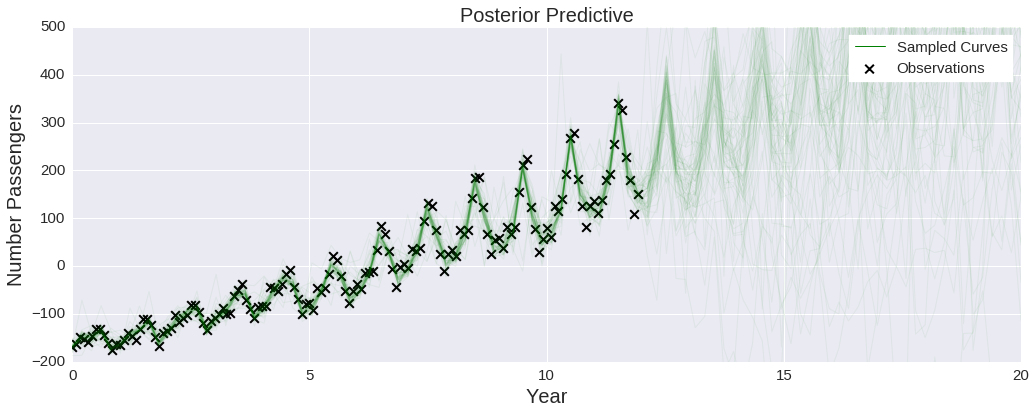

In [11]:
%%venturescript


define plotting_parameters = dict(
        ["label",  "Sampled Curves"],
        ["xlabel", "X"],
        ["ylabel", "Y"],
        ["markersize", 75],
        ["alpha", 0.05],
        ["width", 17],
        ["height", 6],
        ["xlim", array(0, 20)],
        ["ylim", array(-200, 500)]
);
for_each(posterior_predictive,
    (y_prime) -> {
        do(pass,
        action(
            line_plot(x_prime, y_prime, plotting_parameters)))
    } 
);
scatter_plot(data_airline_in, data_airline_out, plotting_parameters_scatter);
title("Posterior Predictive");
legend();